In [3]:
from scipy import stats
import numpy as np #useful for math
import pandas as pd #useful to represent data
from glob import glob #useful to get list of files
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../')
#from intersac_tools import plot_ressac
from navipy.trajectories import Trajectory


%matplotlib inline

In [4]:
# Load list of bees
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
bee_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

An ideal motion parallax is considered when the head is perfectly stabilized durin intersaccade. the head will perform a pure transation.

A theoretical or ideal trajectory is computed by keeping yaw, pitch and roll constant during the intersaccade. The constant YPR orientation are simply the average of the orientation during the intersaccade

In [5]:
def simu_movepar(x):
    '''return yaw, pitch and roll averages during the interssacade'''
    out_x = x.copy()
    out_x[('zyx','alpha_0')] = x.loc[:,('zyx','alpha_0')].mean()
    out_x[('zyx','alpha_1')] = x.loc[:,('zyx','alpha_1')].mean()
    out_x[('zyx','alpha_2')] = x.loc[:,('zyx','alpha_2')].mean()
    return out_x.astype(float)


# Example

In [6]:
beeid = '17'
assert beeid in bee_ids.values, 'Bee id unknwon'

blk_i = 0
key = '/blk_nonans/flight_{}'.format(beeid) 
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

assert blk_i in blknonans.index, 'Block unknown'

In [7]:
# Load the trajectory
key = '/trajectories/flight_{}/blk_{}'.format(beeid,blk_i) 
head_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
head_traj = Trajectory().from_dataframe(head_traj)
lamb = pd.Series(index=head_traj.columns, data=150)
head_traj.filt_cspline(lamb)
head_traj = head_traj.astype(float)
# Load the intersaccade 
key = '/res_sac/flight_{}/blk_{}'.format(beeid,blk_i) 
res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']

In [8]:
intersac_htraj = head_traj.loc[res_sac_head.intersac.dropna().index,:]
intersac_htraj['id_intersac'] = res_sac_head.intersac.dropna()
intersac_htraj.head()

location                             zyx                      \
              x          y          z   alpha_0   alpha_1   alpha_2   
337.0  8.840324 -55.978265  26.415362 -2.453275 -0.158637 -0.097742   
338.0  8.631195 -55.823916  26.350140 -2.454454 -0.162206 -0.099876   
339.0  8.349499 -55.606238  26.270804 -2.456198 -0.166602 -0.102817   
340.0  8.028865 -55.337747  26.198864 -2.458453 -0.171191 -0.106241   
341.0  7.697131 -55.030643  26.150214 -2.461282 -0.175634 -0.109832   

      id_intersac  
                   
337.0         0.0  
338.0         0.0  
339.0         0.0  
340.0         0.0  
341.0         0.0

In [9]:
transformed_htraj_intersac = intersac_htraj.groupby('id_intersac').apply(simu_movepar)
# Reindex as frame because grouping reindex in multiindex, but not necessary for us
transformed_htraj_intersac.index = transformed_htraj_intersac.index.get_level_values(level=1)
# We don't need the id of the inersaccade anymore
transformed_htraj_intersac.drop('id_intersac',inplace=True,axis=1)
# Saccade are untouched, so we copy
# and replace only the affected frames
transformed_htraj = head_traj.copy()
transformed_htraj.loc[transformed_htraj_intersac.index,:] = transformed_htraj_intersac.copy()

Text(0.5, 1.0, 'Constant drift head traj $f(T_h(t))$')

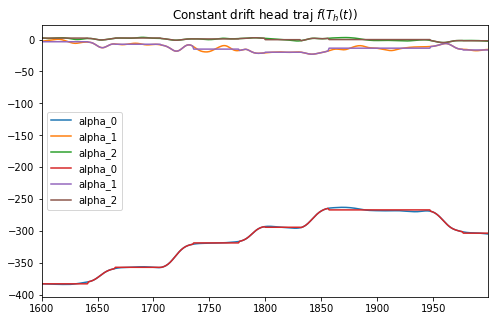

In [15]:
idx = np.arange(1600,2000)
fig,ax = plt.subplots(1,1,sharex=True,figsize=(8,5))

np.rad2deg(head_traj.loc[idx].zyx).plot(ax=ax)
np.rad2deg(transformed_htraj.loc[idx].zyx).plot(ax=ax)
ax.set_title('Constant drift head traj $f(T_h(t))$')




In [ ]:
head_filename_simulated_motion = '../results/idealmotion.hdf'

In [ ]:
# Get the list of bees
bee_ids = pd.read_hdf(head_filename_result, key='flight_ids')
# Loop through the bees
for _, beeid in bee_ids.iteritems():
    # Loop through the block
    key = '/blk_nonans/flight_{}'.format(beeid)
    # Load block no nans for current bee
    blknonans = pd.read_hdf(head_filename_result_blocknonans, key)
    for blk_i, _ in blknonans.iterrows():
        # 0 Load the data
        # Load the trajectory
        key = '/trajectories/flight_{}/blk_{}'.format(beeid,blk_i) 
        head_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
        head_traj = Trajectory().from_dataframe(head_traj)
        lamb = pd.Series(index=head_traj.columns, data=150)
        head_traj.filt_cspline(lamb)
        head_traj = head_traj.astype(float)
        # Load the intersaccade 
        key = '/res_sac/flight_{}/blk_{}'.format(beeid,blk_i) 
        res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
        
        # 
        intersac_htraj = head_traj.loc[res_sac_head.intersac.dropna().index,:]
        intersac_htraj['id_intersac'] = res_sac_head.intersac.dropna()
        if intersac_htraj.shape[0]>0:
            # 1 Apply pivot transform
            transformed_htraj_intersac = intersac_htraj.groupby('id_intersac').apply(simu_movepar)
            # Reindex as frame because grouping reindex in multiindex, but not necessary for us
            transformed_htraj_intersac.index = transformed_htraj_intersac.index.get_level_values(level=1)
            # We don't need the id of the inersaccade anymore
            transformed_htraj_intersac.drop('id_intersac',inplace=True,axis=1)

            # 2 - Recreate full traj
            # Saccade are untouched, so we copy
            # and replace only the affected frames
            transformed_htraj = head_traj.copy()
            transformed_htraj.loc[transformed_htraj_intersac.index,:] = transformed_htraj_intersac.copy()
        else:
            transformed_htraj = head_traj.copy()
        
        # Save in hdf
        key = '/trajectories_nulldrift/flight_{}/blk_{}'.format(beeid,blk_i)
        transformed_htraj.to_hdf(head_filename_simulated_motion, key=key)